This Notebook gathers a simple demo of our SGD code developed the project "Alleviating Label Switching with Optimal Transport". The first part was devoted to the developement of an HMC sampler using Stan software. Then we show a demo of our algorithm on SGD synthetic data.

In [20]:
# List of librairies

import numpy as np
import pystan
import pickle
import matplotlib.pylab as plt
import scipy.linalg
from scipy.spatial import distance_matrix
import ot
import copy
from scipy.stats import multivariate_normal 
import time
import os, os.path
import random
import matplotlib.pyplot as plt


## 1) HMC Sampler and SGD

We need to implement an efficient sampler. We therefore use an Hamiltonian Monte Carlo method with the probabilistic software Stan.

In [3]:
###Generation of a Gaussian Mixture
### Centers are the means of the Gaussian Mixture, mixing_prop the weights, and noise_sd the Covariance matrices

def gen_gaus_mixture(centers, mixing_prop=None, noise_sd=0.1, M=20000):
    
    K, D = centers.shape
    if mixing_prop is None:
        mixing_prop = np.random.dirichlet(np.ones(K)*100)
    assignments = np.random.choice(K, size=M, p=mixing_prop)
    data = np.zeros((M,D))
    
    
    for k in range(K):
        data[assignments==k] = np.random.multivariate_normal(centers[k], noise_sd[k], size=(assignments==k).sum())
        
    return data, mixing_prop

In [4]:
# This should be done only once because compiling the Stan code 
# takes a long time 

# mixture = pystan.StanModel(file='mixture_all.stan')
# with open('stan_mixture_all.pkl', 'wb') as f:
# pickle.dump(mixture, f)

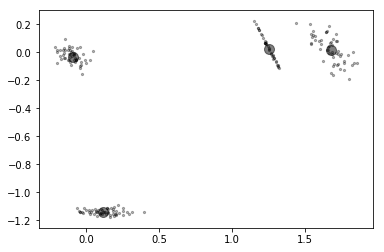

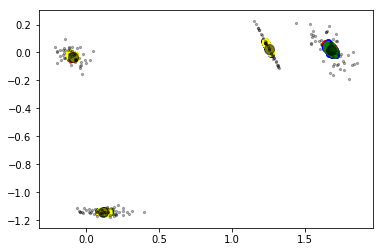

--- 399.703665971756 seconds ---


In [15]:
mixture = pickle.load(open('Stan/stan_mixture_all.pkl', 'rb'))
start_time = time.time()


## Generating and plotting data ##

# Data generating parameters
K = 4 # number of components
D = 2 # data dimension
M = 200 # sample size


#Choice of covariance matrices
cov = np.random.normal(0,0.05, (K,D,D))
for k in range(K):
    cov[k] = cov[k]@np.transpose(cov[k])

local_sd = 0.1
global_sd = np.sqrt(K)*0.5 # sigma0
mu0 = 0. # mu0

centers = np.random.normal(mu0,global_sd,size=(K,D))
X, mix = gen_gaus_mixture(centers, mixing_prop=None, noise_sd=cov, M=M)

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.show()


## HMC part with Stan ##


stan_data = {'D': D, 'K':K, 'N':M, 'y':X, 'alpha':np.ones(K)*10}

chains = 3

#initialisation of each chain
init = []
for c in range(chains):
    c_init = {'mu': np.random.normal(scale=global_sd, size=(K,D)), 'theta': np.ones(K)/K,
              'L': [np.eye(D) for _ in range(K)],
              'sigma': [np.ones(D)*local_sd for _ in range(K)]}
    init.append(c_init)
    

control={ 'adapt_delta':0.8 , 'stepsize_jitter':0.15}
fit_nuts = mixture.sampling(data=stan_data, iter=1000, chains=chains, n_jobs=-1, init=init, control=control)
la = fit_nuts.extract(permuted=True)


## plot the results ##

colors = ['red', 'blue', 'green', 'yellow']
for k in range(K):
    plt.scatter(la['mu'][:,k,0], la['mu'][:,k,1], c=colors[k])
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.show()


print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
means, covs, weights, Data, likelihood= la['mu'], la['Sigma'], la['theta'].reshape((1500,4,1)), X, la['lp__']

After having implemented the HMC sampler, we need to implement our Wassertein based SGD algorithm. Also, the warnings below our HMC sampler are due to the fact that there is the label switching issue and therefore the chains results do not match all together.

In [17]:
def SGD(means, covs, weights, N=1000, D=2, K=4):
    start_time = time.time()
    mus = means
    mu_barre = np.random.normal(size=(K,D))
    Cov_barre  = np.array([ np.identity(D), np.identity(D),np.identity(D),np.identity(D)])
    sigma_barre = np.zeros((K,D,D))
    for i in range(K):
        sigma_barre[i] = scipy.linalg.cholesky(Cov_barre[i])
    weights_barre = (np.ones(K)/K).reshape((4,1))
    a = [1/K]*K
    b = [1/K]*K
    h = [[], [],[],[]]
    for loop in range(1000) :
        learning_rate = 1/(loop+1)
        sigma = np.zeros((K,D,D))
        for i in range(K):
            sigma[i] = scipy.linalg.sqrtm(covs[loop,i])

        M = distance_matrix(mus[loop], mu_barre, p = 2)
        M = M**2
        M = np.ascontiguousarray(M)
        N = distance_matrix(weights[loop], weights_barre, p = 2)
        N = N**2
        N = np.ascontiguousarray(N)
        M=M+N
        for j in range(K):
            A = sigma_barre[j]@np.transpose(sigma_barre[j])
            A_demi = scipy.linalg.sqrtm(A)
            for i in range(K):
                M[i,j] += np.trace(A + covs[loop,i]- 2 * scipy.linalg.sqrtm(A_demi@covs[loop,i]@A_demi))
        T = ot.emd(a, b, M) 
        
        idx_map = np.where(T)
        learning_rate = 1/np.sqrt(loop+1)
        for j in range(K):
            s = (mu_barre[j] - mus[loop])*T[:,j].reshape(-1,1)
            mu_barre[j] -= learning_rate*2*s.sum(axis=0)
            h[j].append(copy.deepcopy(mu_barre[j]))
            assert(len(np.nonzero(T[:,j]))==1)
            i = np.nonzero(T[:,j])[0][0]                      
            A = sigma_barre[j]@np.transpose(sigma_barre[j])
            A_demi = scipy.linalg.sqrtm(A)
            T_AB =  np.real( np.linalg.inv(A_demi) @ scipy.linalg.sqrtm(A_demi@covs[loop,i]@A_demi) @  np.linalg.inv(A_demi))
            sigma_barre[j] -= learning_rate*2*(np.identity(D)-T_AB)@sigma_barre[j]
            weights_barre[j] -= learning_rate*2*weights[loop, i]

    for i in range(K):
        Cov_barre[i] = sigma_barre[i]@np.transpose(sigma_barre[i])
        
    return mu_barre, h, Cov_barre, weights_barre, time.time() - start_time


In [18]:
mu_barre, h, Cov_barre, weights_barre, timing = SGD(means, covs, weights, N=1500, D=2, K=4)

We finally plot the trajectory of our barycenter in the $(\mu_1, \mu_2)$ plane 

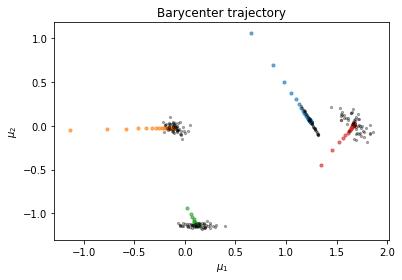

In [19]:
for i in range(K):
    x,y = zip(*h[i][:50])
    plt.scatter(x,y, s=10, alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c='black', s=5, alpha=0.3)
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.title('Barycenter trajectory')
plt.show()